<a href="https://colab.research.google.com/github/YoshiaAbe/SketchWorldModels/blob/dev_hara/CLIPassoWithNeuralRenderer_saliencymap_smallradius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setup for CLIP and diffvg
*** when finished the cell, restart runtime ***

In [ ]:
%cd /usr/local/
!pwd
!ls
!rm -rf cuda
!ln -s /usr/local/cuda-10.1 /usr/local/cuda
!stat cuda
!nvcc --version
%cd /content/
!git clone https://github.com/yael-vinker/CLIPasso.git
%cd CLIPasso
!pip install -r requirements.txt
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
%cd /content/CLIPasso
!git pull
%cd /content/CLIPasso
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/BachiLi/diffvg
%cd diffvg
!git submodule update --init --recursive
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("/content/CLIPasso/diffvg/build/lib.linux-x86_64-3.7")
!pip3 install 
!python setup.py install

/usr/local
/usr/local
bin	   cuda-10.1  cuda-11.1  _gcs_config_ops.so  licensing	share
cuda	   cuda-11    etc	 include	     man	src
cuda-10.0  cuda-11.0  games	 lib		     sbin	xgboost
  File: cuda -> /usr/local/cuda-10.1
  Size: 20        	Blocks: 0          IO Block: 4096   symbolic link
Device: 24h/36d	Inode: 2766445     Links: 1
Access: (0777/lrwxrwxrwx)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2022-04-13 13:33:26.508093506 +0000
Modify: 2022-04-13 13:33:26.402083591 +0000
Change: 2022-04-13 13:33:26.402083591 +0000
 Birth: -
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
/content
Cloning into 'CLIPasso'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 325 (delta 169), reused 131 (delta 55), pack-reused 0
Receiving objects: 100% (325/325), 10.06 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 77.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2
    Uninstalling torchvision-0.8.2:
      Successfully uninstalled torchvision-0.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1+cu101 which is incompatible.
/content/CLIPasso
Already up to date.
/content/CLIPasso
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build

### Define Neural Renderer

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F 

# mainの定数
CANVAS_SIZE = 224
CANVAS_H = CANVAS_SIZE
CANVAS_W = CANVAS_SIZE
CANVAS_C = 3
NUM_CONTROL_POINTS=4

# neural rendererの定義
class NeuralRenderer(nn.Module):
    def __init__(self, num_control_points):
        super().__init__()
        self.fc1 = nn.Linear(num_control_points*2, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 4096)
        self.fc5 = nn.Linear(4096, 6272)
        self.conv1 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv6 = nn.Conv2d(32, 32, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(32)
        self.conv7 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv8 = nn.Conv2d(16, 12, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = x.view(-1, 32, 14, 14)
        x = F.relu(self.conv1(x))
        x = self.pixel_shuffle(self.norm1(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pixel_shuffle(self.norm2(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pixel_shuffle(self.norm3(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.pixel_shuffle(self.conv8(x))
        x = torch.sigmoid(x)
        return x.permute(0,2,3,1)

### Define Rasterizer

In [ ]:
# Download parametes
!wget https://gist.github.com/takehr/3582fb96039c8f40b9908fe70e3e8393/raw/592f36e2aecffbd88f917af87415abeef64eaeb5/xaa
!wget https://gist.github.com/takehr/3582fb96039c8f40b9908fe70e3e8393/raw/592f36e2aecffbd88f917af87415abeef64eaeb5/xab
!cat ./x* > params.pkl
class Rasterizer():
  def __init__(self, num_strokes):
    self.renderers = [NeuralRenderer(NUM_CONTROL_POINTS) for _ in range(num_strokes)]
    NeuralRenderer(NUM_CONTROL_POINTS)
    for renderer in self.renderers: 
      renderer.load_state_dict(torch.load("params.pkl"))
      renderer.to("cuda")
  def forward(self, control_points):
    return self.sum_imgs(torch.stack([renderer(control_point) for control_point, renderer in zip(control_points, self.renderers)]))
  def sum_imgs(self, imgs):
    return 1 - torch.sigmoid( (torch.sum(1-imgs, dim=0) - 0.5) * 10)
  def zero_grad(self):
    for renderer in self.renderers: renderer.zero_grad()

--2022-04-13 13:57:30--  https://gist.github.com/takehr/3582fb96039c8f40b9908fe70e3e8393/raw/592f36e2aecffbd88f917af87415abeef64eaeb5/xaa
Resolving gist.github.com (gist.github.com)... 52.192.72.89
Connecting to gist.github.com (gist.github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gist.githubusercontent.com/takehr/3582fb96039c8f40b9908fe70e3e8393/raw/592f36e2aecffbd88f917af87415abeef64eaeb5/xaa [following]
--2022-04-13 13:57:30--  https://gist.githubusercontent.com/takehr/3582fb96039c8f40b9908fe70e3e8393/raw/592f36e2aecffbd88f917af87415abeef64eaeb5/xaa
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73773109 (70M) [application/octet-stream]
Saving to: ‘xaa’

xaa                 1

### Define CLIP

In [ ]:
import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

class CLIPConvLoss(torch.nn.Module):
    def __init__(self):
        super(CLIPConvLoss, self).__init__()
        self.model, clip_preprocess = clip.load("RN101", "cuda", jit=False)

        self.visual_model = self.model.visual
        layers = list(self.model.visual.children())
        init_layers = torch.nn.Sequential(*layers)[:8]
        self.layer1 = layers[8]
        self.layer2 = layers[9]
        self.layer3 = layers[10]
        self.layer4 = layers[11]
        self.att_pool2d = layers[12]

        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            clip_preprocess.transforms[0],  # Resize
            clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])

        self.model.eval()
        self.num_augs = 4 # for avoiding an adversarial sketch

        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            224, scale=(0.8, 0.8), ratio=(1.0, 1.0)))
        augemntations.append(
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)))
        self.augment_trans = transforms.Compose(augemntations)

    def forward(self, sketch, target):
        conv_loss_dict = {}
        x = sketch.to("cuda")
        y = target.to("cuda")
        sketch_augs, img_augs = [self.normalize_transform(x)], [
            self.normalize_transform(y)]
    
        for n in range(self.num_augs):
            augmented_pair = self.augment_trans(torch.cat([x, y]))
            sketch_augs.append(augmented_pair[0].unsqueeze(0))
            img_augs.append(augmented_pair[1].unsqueeze(0))

        xs = torch.cat(sketch_augs, dim=0).to("cuda")
        ys = torch.cat(img_augs, dim=0).to("cuda")

        xs_fc_features, xs_conv_features = self.forward_inspection_clip_resnet(
            xs.contiguous())
        ys_fc_features, ys_conv_features = self.forward_inspection_clip_resnet(
            ys.detach())

        conv_loss = [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in zip(xs_conv_features, ys_conv_features)]
        fc_loss = (1 - torch.cosine_similarity(xs_fc_features, ys_fc_features, dim=1)).mean()
            
        return sum(conv_loss) + 0.1 * fc_loss

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x2, x3]

### Optimize Control Points

In [ ]:
from PIL import Image
import PIL

def get_target(img_path):
    target = Image.open(img_path)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (224, 224), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            224, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(224))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to("cuda")
    return target_

## Generate Saliency map and Initialization Control points

### Module import

In [ ]:
### Saliency map生成から初めのControl points生成までに必要なライブラリ. （以前にインポートしているものも含まれる.）
import PIL
from PIL import Image
import numpy as np
import torch

import matplotlib.pyplot as plt
import wandb
import random

from torchvision import transforms
from torchvision.utils import make_grid

import CLIPasso.CLIP_.clip as clip

from scipy.ndimage.filters import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

### Define interpret function

In [ ]:
def interpret(image, texts, model, device):
    images = image.repeat(1, 1, 1, 1)
    res = model.encode_image(images)
    model.zero_grad()
    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(1, num_tokens, num_tokens)
    cams = [] # there are 12 attention blocks
    for i, blk in enumerate(image_attn_blocks):
        cam = blk.attn_probs.detach() #attn_probs shape is 12, 50, 50
        # each patch is 7x7 so we have 49 pixels + 1 for positional encoding
        cam = cam.reshape(1, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0)
        cam = cam.clamp(min=0).mean(dim=1) # mean of the 12 something
        cams.append(cam)  
        R = R + torch.bmm(cam, R)
              
    cams_avg = torch.cat(cams) # 12, 50, 50
    cams_avg = cams_avg[:, 0, 1:] # 12, 1, 49
    image_relevance = cams_avg.mean(dim=0).unsqueeze(0)
    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bicubic')
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy().astype(np.float32)
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    return image_relevance

### Define XDoG

In [ ]:
class XDoG_(object):
    def __init__(self):
        super(XDoG_, self).__init__()
        self.gamma=0.98
        self.phi=200
        self.eps=-0.1
        self.sigma=0.8
        self.binarize=True
        
    def __call__(self, im, k=10):
        if im.shape[2] == 3:
            im = rgb2gray(im)
        imf1 = gaussian_filter(im, self.sigma)
        imf2 = gaussian_filter(im, self.sigma * k)
        imdiff = imf1 - self.gamma * imf2
        imdiff = (imdiff < self.eps) * 1.0  + (imdiff >= self.eps) * (1.0 + np.tanh(self.phi * imdiff))
        imdiff -= imdiff.min()
        imdiff /= imdiff.max()
        if self.binarize:
            th = threshold_otsu(imdiff)
            imdiff = imdiff >= th
        imdiff = imdiff.astype('float32')
        return imdiff

In [ ]:
class AttentionMap(torch.nn.Module):
    def __init__(self,
                 num_paths=16,
                 imsize=224,
                 target_im=None,
                 num_control_points=4):
        super(AttentionMap, self).__init__()

        self.num_paths = num_paths # number of strokes
        self.num_stages = 1 # "training stages, you can train x strokes, then freeze them and train another x strokes etc."
        self.softmax_temp = 0.3 # from config.py default
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.canvas_width, self.canvas_height = imsize, imsize
        
        self.text_target = "none" # from config.py defualt, for clip gradients
        self.saliency_clip_model = "ViT-B/32" # from config.py default
        
        self.define_attention_input(target_im)
        self.attention_map = self.clip_attn()
        self.thresh = self.set_inds_clip()

        self.target_img = target_im
        self.num_control_points = num_control_points

        self.strokes_counter = 0

    def define_attention_input(self, target_im):
        model, preprocess = clip.load(self.saliency_clip_model, device=self.device, jit=False)
        model.eval().to(self.device)
        data_transforms = transforms.Compose([
                    preprocess.transforms[-1],
                ])
        self.image_input_attn_clip = data_transforms(target_im).to(self.device)

    def clip_attn(self):
        model, preprocess = clip.load(self.saliency_clip_model, device=self.device, jit=False)
        model.eval().to(self.device)
        text_input = clip.tokenize([self.text_target]).to(self.device)

        attn_map = interpret(self.image_input_attn_clip, text_input, model, device=self.device)
            
        del model
        return attn_map

    def softmax(self, x, tau=0.2):
        e_x = np.exp(x / tau)
        return e_x / e_x.sum() 

    def set_inds_clip(self):
        attn_map = (self.attention_map - self.attention_map.min()) / (self.attention_map.max() - self.attention_map.min())

        # xdog_intersec
        xdog = XDoG_()
        im_xdog = xdog(self.image_input_attn_clip[0].permute(1,2,0).cpu().numpy(), k=10)
        intersec_map = (1 - im_xdog) * attn_map
        attn_map = intersec_map
            
        attn_map_soft = np.copy(attn_map)
        attn_map_soft[attn_map > 0] = self.softmax(attn_map[attn_map > 0], tau=self.softmax_temp)

        k = self.num_stages * self.num_paths
        self.inds = np.random.choice(range(attn_map.flatten().shape[0]), size=k, replace=False, p=attn_map_soft.flatten())
        self.inds = np.array(np.unravel_index(self.inds, attn_map.shape)).T

        self.inds_normalised = np.zeros(self.inds.shape)
        self.inds_normalised[:, 0] = self.inds[:, 1] / self.canvas_width
        self.inds_normalised[:, 1] = self.inds[:, 0] / self.canvas_height
        self.inds_normalised = self.inds_normalised.tolist()
        return attn_map_soft

    ### show attention map
    def show_attn(self):
        def plot_attn_clip(attn, threshold_map, inputs, inds):
            # currently supports one image (and not a batch)
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 3, 1)
            main_im = make_grid(inputs, normalize=True, pad_value=2)
            main_im = np.transpose(main_im.cpu().numpy(), (1, 2, 0))
            plt.imshow(main_im, interpolation='nearest')
            plt.scatter(inds[:, 1], inds[:, 0], s=10, c='red', marker='o')
            plt.title("input im")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(attn, interpolation='nearest', vmin=0, vmax=1)
            plt.title("atn map")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            threshold_map_ = (threshold_map - threshold_map.min()) / \
                (threshold_map.max() - threshold_map.min())
            plt.imshow(threshold_map_, interpolation='nearest', vmin=0, vmax=1)
            plt.title("prob softmax")
            plt.scatter(inds[:, 1], inds[:, 0], s=10, c='red', marker='o')
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

        plot_attn_clip(self.attention_map, self.thresh, self.target_img, self.inds)

    def get_init_points(self):
        control_points = []
        for i in range(self.num_paths):
          points = []
          p0 = self.inds_normalised[self.strokes_counter] #(random.random(), random.random())
          points.append(p0)

          radius = 0.05
          for k in range(self.num_control_points - 1):
              p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
              points.append(p1)
              p0 = p1
          points = torch.tensor(points,requires_grad=True,device=self.device).float()
          points = torch.flatten(points)
          points = torch.tensor(torch.unsqueeze(points, 0).tolist(), requires_grad=True, device=self.device).float()
          control_points.append(points)
          self.strokes_counter += 1
        return control_points

In [ ]:
from tqdm import tqdm
import random
img_path = "./CLIPasso/target_images/camel.png"
input= get_target(img_path)
NUM_STROKES = 8

#----------  コントロールポイントの初期化  ------------------------------------
# control_points = []
# for i in range(NUM_STROKES):
#   points = []
#   p0 = (random.random(), random.random())
#   points.append(p0)

#   radius = 0.05
#   for k in range(NUM_CONTROL_POINTS - 1):
#       p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
#       points.append(p1)
#       p0 = p1
#   points = torch.tensor(points,requires_grad=True,device="cuda").float()
#   points = torch.flatten(points)
#   points = torch.tensor(torch.unsqueeze(points, 0).tolist(), requires_grad=True, device="cuda").float()
#   control_points.append(points)
# print(control_points)

#----------  Saliency Mapを使ったコントロールポイントの初期化  -------------------
saliency_map = AttentionMap(num_paths=NUM_STROKES, imsize=CANVAS_SIZE, target_im=input, num_control_points=NUM_CONTROL_POINTS)
saliency_map.show_attn()
control_points = saliency_map.get_init_points()
print(control_points)

#---------- モデルの初期化 ----------------------------------------------------
clip_loss = CLIPConvLoss()
rasterizer = Rasterizer(NUM_STROKES)
optimizer = torch.optim.Adam(control_points, lr=0.01)
sketch = None
losses = []

#----------------  Optimization Loop -------------------------------------------
for epoch in tqdm(range(2000)):

    if epoch % 10 == 0:
      # print("-------{} epoch ----------------------".format(epoch))
      # print(control_points)
      # print("loss: ", losses[-1] if len(losses) > 0 else "init")
      plt.imsave("{}.jpg".format(epoch), rasterizer.forward(control_points).cpu().detach().numpy()[0])
    
    optimizer.zero_grad()
    sketch = rasterizer.forward(control_points = control_points).permute(0,3,1,2)# NHWC -> NCHW
    loss = clip_loss(sketch, input.detach())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [05:52<00:00,  5.68it/s]


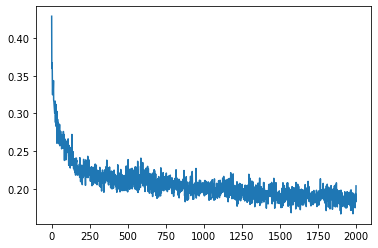

In [ ]:
plt.plot(losses)

In [ ]:
!rm out.mp4
!ffmpeg -r 30 -i %d0.jpg -vcodec libx264 -pix_fmt yuv420p -r 60 out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
import moviepy.editor as mvp
display(mvp.ipython_display("out.mp4"))